### G76 vs G74

Compare run 76 vs 74

G76 is the out-of-the-box configuration for the CESM2.2 release, see https://github.com/ESCOMP/MOM_interface/pull/65

In [20]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6plot import xyplot, yzplot 
from mom6_tools.m6toolbox import genBasinMasks
warnings.filterwarnings("ignore")

In [21]:
path = '/glade/scratch/gmarques/'
exps = ['g.c2b6.GJRA.TL319_t061.long_JRA_mct.076',\
        'g.c2b6.GJRA.TL319_t061.long_JRA_mct.074']
labels = ['G76', 'G74']

def get_data(full_path, variables):
  def preprocess(ds):
    ''' Return the dataset with variable'''
    return ds[variables]
  ds = xr.open_mfdataset(full_path, data_vars='minimal', \
                         coords='minimal', compat='override', preprocess=preprocess)
  return ds

import seaborn, matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [22]:
# load pre-difined masks
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.m6plot import ztplot, polarplot, xyplot, xycompare
import cartopy.crs as ccrs
import cartopy.feature
grd = MOM6grid(path+exps[0]+'/run/'+exps[0]+'.mom6.static.nc')
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True)

MOM6 grid successfully loaded... 

11.16427964664149 64.78854837178643 [391, 434]


/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.076/run/*mom6.hm_00*.nc
/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.074/run/*mom6.hm_00*.nc


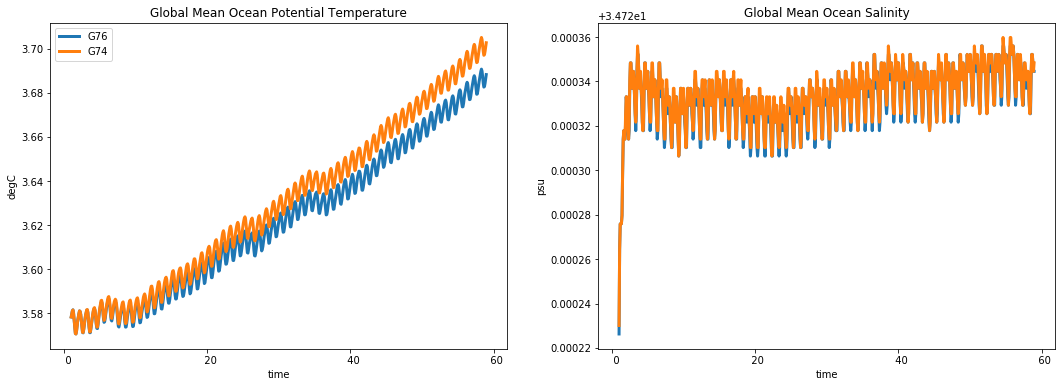

In [23]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
variables = ['thetaoga', 'soga']
for i in range(len(exps)):
  tmp = path+exps[i]+'/run/*mom6.hm_00*.nc'
  print(tmp)
  ds = get_data(tmp,variables)
  ds1 = ds.sel(time=slice('0001-01-01', '0059-01-01'))
  ds1['thetaoga'].plot(ax=ax[0], label=labels[i], lw=3)
  ds1['soga'].plot(ax=ax[1], lw=3)

ax[0].set_title(ds1.thetaoga.attrs['long_name']); ax[0].set_ylabel(ds1.thetaoga.attrs['units'])
ax[1].set_title(ds1.soga.attrs['long_name']); ax[1].set_ylabel(ds1.soga.attrs['units']); ax[0].legend()

/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.076/run/ocean.stats.nc
/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.074/run/ocean.stats.nc


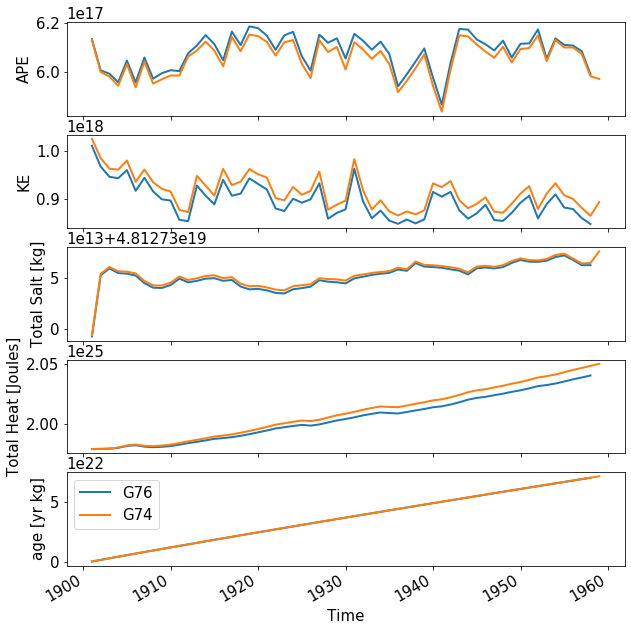

In [24]:
import pandas as pd
plt.rcParams.update({'font.size': 15})
variables = ['APE', 'KE', 'Salt', 'Heat', 'age']
fig, ax = plt.subplots(nrows=len(variables), ncols=1, figsize=(10,10), sharex=True)
for i in range(len(exps)): 
  path_to_file = path+exps[i]+'/run/ocean.stats.nc'
  print(path_to_file)
  ds = xr.open_dataset(path_to_file)
  time = pd.date_range('1900-01-01', periods=len(ds.Time), freq='D')

  ds['Time'] = time[:]  
  ds1 = ds.resample(Time="1Y", closed='left', keep_attrs=True).mean(dim='Time', keep_attrs=True)   
  ds2 = ds1.sel(Time=slice('1900-01-01', '1959-01-01'))
  for var, j in zip(variables, range(len(variables))):
    if len(ds2[var].shape) > 1:
        tmp = ds2[var].sum(axis=1)
    else:
        tmp = ds2[var]
    tmp.plot(ax=ax[j], label=labels[i], lw=2)
    ax[j].set_xlabel('')
    
ax[j].set_xlabel('Time'); ax[j].legend()

# Mixed layer depth

In [25]:
filepath = '/glade/work/gmarques/cesm/datasets/MLD/deBoyer/deBoyer_MLD_remapped_to_tx06v1.nc'
print('\n Reading climatology from: ', filepath)
mld_obs = xr.open_dataset(filepath)
months = [0,1,2]
obs_JFM = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
months = [6,7,8]
obs_JAS = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
obs_winter = obs_JAS.copy(); obs_summer = obs_JAS.copy()
j = np.abs( grd.geolat[:,0] - 0. ).argmin()
obs_winter[j::,:] = obs_JFM[j::,:]
obs_summer[0:j,:] = obs_JFM[0:j,:]

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
def add_labels(ax, nh='JFM', sh='JAS'):
    ax.plot([grd.geolon[0,0], grd.geolon[0,-1]], [0,0], 'k--', lw=0.5)
    ax.text(25, 7, nh, ha="center", va="center", size=12, bbox=bbox_props)
    ax.text(25, -7, sh, ha="center", va="center", size=12, bbox=bbox_props)


 Reading climatology from:  /glade/work/gmarques/cesm/datasets/MLD/deBoyer/deBoyer_MLD_remapped_to_tx06v1.nc


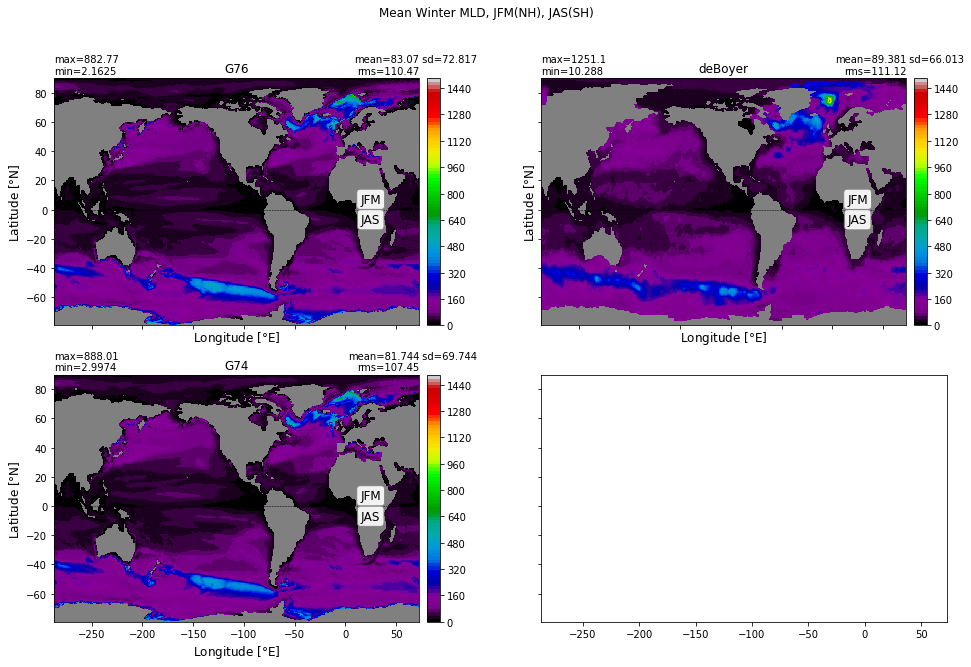

In [26]:
%matplotlib inline
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,10), sharex=True, sharey=True)
ax1 = ax.flatten()
plt.suptitle('Mean Winter MLD, JFM(NH), JAS(SH)')
for i in range(len(exps)):    
  if i == 0:
   ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_winter.nc')
   control = np.ma.masked_invalid(ds.MLD_winter.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,1500), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i])
  else:
   ds = xr.open_dataset('../../'+exps[i]+'/first_cycle/ncfiles/'+exps[i]+'_MLD_winter.nc')
   var = np.ma.masked_invalid(ds.MLD_winter.values) 
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i+1], clim=(0,1500),
         colormap=plt.cm.nipy_spectral, nbins=100); add_labels(ax1[i+1])

xyplot(obs_winter, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,1500), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1])

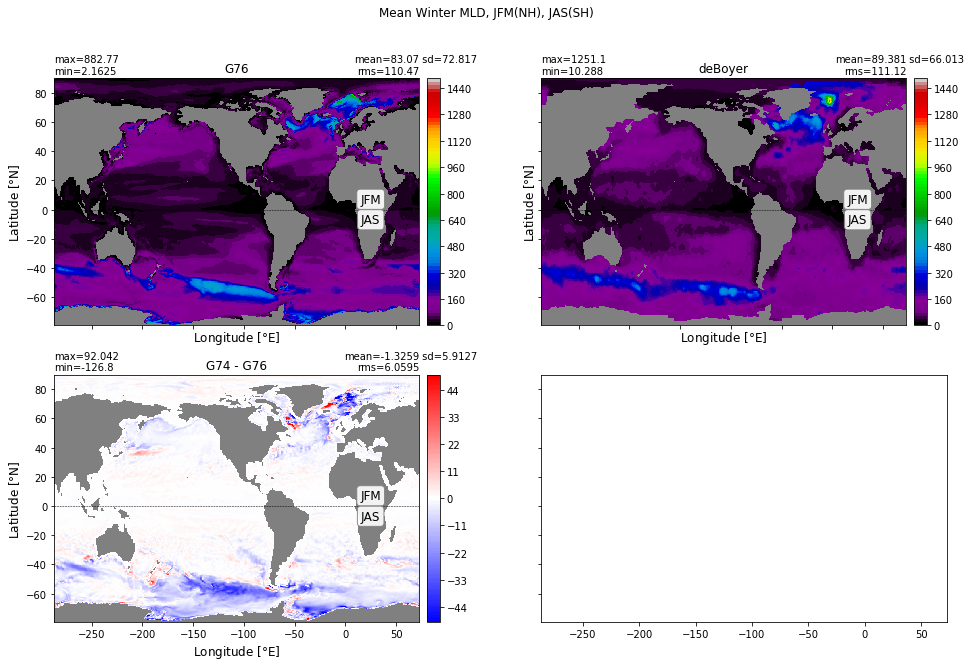

In [27]:
%matplotlib inline
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,10), sharex=True, sharey=True)
ax1 = ax.flatten()
plt.suptitle('Mean Winter MLD, JFM(NH), JAS(SH)')
for i in range(len(exps)):
  
  if i == 0:
   ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_winter.nc')
   control = np.ma.masked_invalid(ds.MLD_winter.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,1500), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i])
  else:
   ds = xr.open_dataset('../../'+exps[i]+'/first_cycle/ncfiles/'+exps[i]+'_MLD_winter.nc')
   var = np.ma.masked_invalid(ds.MLD_winter.values) - control
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]) + ' - ' + str(labels[i-1]), axis=ax1[i+1], clim=(-50,50),
         colormap=plt.cm.bwr, extend='neither', centerlabels=True, nbins=100); add_labels(ax1[i+1])

xyplot(obs_winter, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,1500), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1])

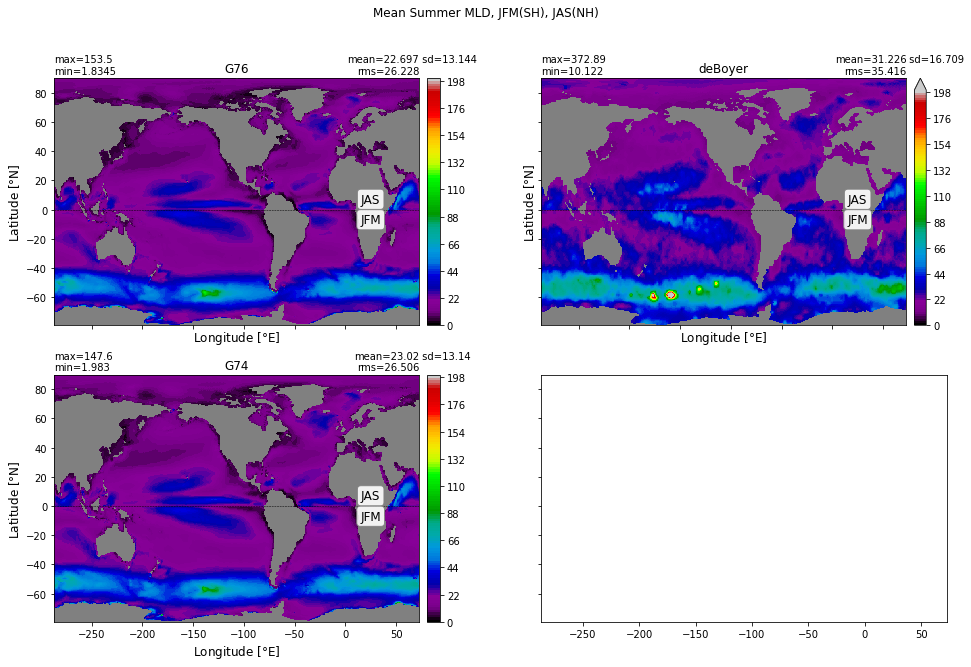

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,10), sharex=True, sharey=True)
ax1 = ax.flatten()
plt.suptitle('Mean Summer MLD, JFM(SH), JAS(NH)')
for i in range(len(exps)):
  if i == 0:
   ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_summer.nc')
   control = np.ma.masked_invalid(ds.MLD_summer.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,200), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i], sh='JFM', nh='JAS')
  else:
   ds = xr.open_dataset('../../'+exps[i]+'/first_cycle/ncfiles/'+exps[i]+'_MLD_summer.nc')
   var = np.ma.masked_invalid(ds.MLD_summer.values) 
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i+1], clim=(0,200), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i+1], sh='JFM', nh='JAS')

xyplot(obs_summer, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,200), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1], sh='JFM', nh='JAS')

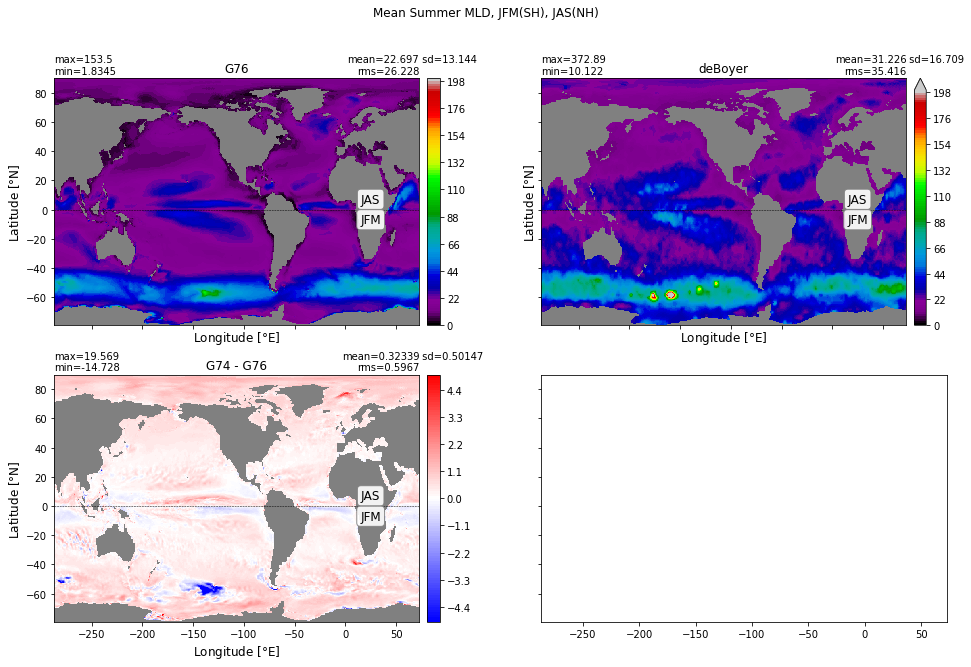

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,10), sharex=True, sharey=True)
ax1 = ax.flatten()
plt.suptitle('Mean Summer MLD, JFM(SH), JAS(NH)')
for i in range(len(exps)):
  
  if i == 0:
   ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_summer.nc')
   control = np.ma.masked_invalid(ds.MLD_summer.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,200), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i], sh='JFM', nh='JAS')
  else:
   ds = xr.open_dataset('../../'+exps[i]+'/first_cycle/ncfiles/'+exps[i]+'_MLD_summer.nc')
   var = np.ma.masked_invalid(ds.MLD_summer.values) - control
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]) + ' - ' + str(labels[i-1]), axis=ax1[i+1], clim=(-5,5),
         colormap=plt.cm.bwr, extend='neither', centerlabels=True, nbins=100); add_labels(ax1[i+1], sh='JFM', nh='JAS')

xyplot(obs_summer, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,200), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1], sh='JFM', nh='JAS')

# Poleward Heat Transport

In [30]:
def get_heat_transport_obs():
  import netCDF4
  """Plots model vs obs poleward heat transport for the global, Pacific and Atlantic basins"""
  # Load Observations
  fObs = netCDF4.Dataset('/glade/work/gmarques/cesm/datasets/Trenberth_and_Caron_Heat_Transport.nc')
  #Trenberth and Caron
  yobs = fObs.variables['ylat'][:]
  NCEP = {}; NCEP['Global'] = fObs.variables['OTn']
  NCEP['Atlantic'] = fObs.variables['ATLn'][:]; NCEP['IndoPac'] = fObs.variables['INDPACn'][:]
  ECMWF = {}; ECMWF['Global'] = fObs.variables['OTe'][:]
  ECMWF['Atlantic'] = fObs.variables['ATLe'][:]; ECMWF['IndoPac'] = fObs.variables['INDPACe'][:]

  #G and W
  Global = {}
  Global['lat'] = np.array([-30., -19., 24., 47.])
  Global['trans'] = np.array([-0.6, -0.8, 1.8, 0.6])
  Global['err'] = np.array([0.3, 0.6, 0.3, 0.1])

  Atlantic = {}
  Atlantic['lat'] = np.array([-45., -30., -19., -11., -4.5, 7.5, 24., 47.])
  Atlantic['trans'] = np.array([0.66, 0.35, 0.77, 0.9, 1., 1.26, 1.27, 0.6])
  Atlantic['err'] = np.array([0.12, 0.15, 0.2, 0.4, 0.55, 0.31, 0.15, 0.09])

  IndoPac = {}
  IndoPac['lat'] = np.array([-30., -18., 24., 47.])
  IndoPac['trans'] = np.array([-0.9, -1.6, 0.52, 0.])
  IndoPac['err'] = np.array([0.3, 0.6, 0.2, 0.05,])

  GandW = {}
  GandW['Global'] = Global
  GandW['Atlantic'] = Atlantic
  GandW['IndoPac'] = IndoPac
  return NCEP, ECMWF, GandW, yobs

NCEP, ECMWF, GandW, yobs = get_heat_transport_obs()
from mom6_tools.poleward_heat_transport import annotateObs, plotGandW, plotHeatTrans, heatTrans

In [31]:
def get_adv_diff(ds):
  # create a ndarray subclass
  class C(np.ndarray): pass

  varName = 'T_ady_2d'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds[varName].values)
    tmp = tmp[:].filled(0.)
    advective = tmp.view(C)
    advective.units = 'W'
  else:
    raise Exception('Could not find "T_ady_2d"')

  varName = 'T_diffy_2d'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds[varName].values)
    tmp = tmp[:].filled(0.)
    diffusive = tmp.view(C)
    diffusive.units = 'W'
  else:
    diffusive = None
    warnings.warn('Diffusive temperature term not found. This will result in an underestimation of the heat transport.')

  varName = 'T_lbm_diffy'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds_sel[varName].sum('z_l').values)
    tmp = tmp[:].filled(0.)
    diffusive = diffusive + tmp.view(C)
  else:
    warnings.warn('Lateral boundary mixing term not found. This will result in an underestimation of the heat transport.')
    
  return advective, diffusive

(-2.5, 2.5)

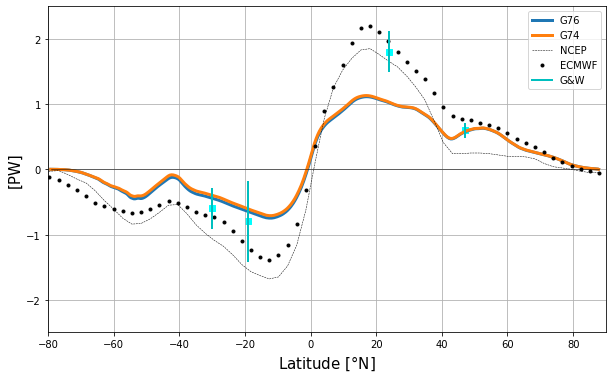

In [32]:
# Global Heat Transport
plt.figure(figsize=(10,6))
for i in range(len(exps)):
  if i == 0:
    ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_heat_transport.nc')
  else:
    ds = xr.open_dataset('../../'+exps[i]+'/first_cycle/ncfiles/'+exps[i]+'_heat_transport.nc')
  adv, diff = get_adv_diff(ds);   HT = heatTrans(adv,diff); y = ds.yq;   plt.plot(y, HT, linewidth=3,label=labels[i]);     
plt.xlim(-80,90); plt.ylim(-2.5,3.0); plt.grid(True); plt.plot(y, y*0., 'k', linewidth=0.5); plt.plot(yobs,NCEP['Global'],'k--',linewidth=0.5,label='NCEP'); 
plt.plot(yobs,ECMWF['Global'],'k.',linewidth=0.5,label='ECMWF'); plotGandW(GandW['Global']['lat'],GandW['Global']['trans'],GandW['Global']['err']); plt.xlabel(r'Latitude [$\degree$N]',fontsize=15)
plt.ylabel('[PW]',fontsize=15); plt.legend(loc=0,fontsize=10)
plt.ylim(-2.5,2.5)

In [33]:
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth)

11.16427964664149 64.78854837178643 [391, 434]


(0, 1.8)

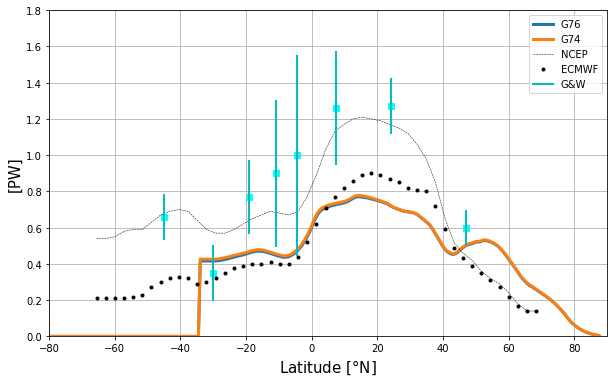

In [34]:
# Atlantic Heat Transport
m = 0*basin_code; m[(basin_code==2) | (basin_code==4) | (basin_code==6) | (basin_code==7) | (basin_code==8)] = 1
plt.figure(figsize=(10,6))
for i in range(len(exps)):
  if i == 0:
    ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_heat_transport.nc')
  else:
    ds = xr.open_dataset('../../'+exps[i]+'/first_cycle/ncfiles/'+exps[i]+'_heat_transport.nc')
    
  adv, diff = get_adv_diff(ds);   HT = heatTrans(adv,diff, vmask=m*np.roll(m,-1,axis=-2)); y = ds.yq;   plt.plot(y, HT, linewidth=3,label=labels[i]);     
plt.xlim(-80,90); plt.ylim(-0.1,2.0); plt.grid(True); plt.plot(y, y*0., 'k', linewidth=0.5); plt.plot(yobs,NCEP['Atlantic'],'k--',linewidth=0.5,label='NCEP'); 
plt.plot(yobs,ECMWF['Atlantic'],'k.',linewidth=0.5,label='ECMWF'); plotGandW(GandW['Atlantic']['lat'],GandW['Atlantic']['trans'],GandW['Atlantic']['err']); plt.xlabel(r'Latitude [$\degree$N]',fontsize=15)
plt.ylabel('[PW]',fontsize=15); plt.legend(loc=0,fontsize=10)
plt.ylim(0,1.8)

## T/S bias at selected vertical levels

In [35]:
# load PHC2 data
phc_path = '/glade/p/cesm/omwg/obs_data/phc/'
phc_temp_mom = xr.open_mfdataset(phc_path+'PHC2_TEMP_tx0.66v1_34lev_ann_avg.nc', 
                             decode_coords=False, decode_times=False)
phc_salt_mom = xr.open_mfdataset(phc_path+'PHC2_SALT_tx0.66v1_34lev_ann_avg.nc', 
                             decode_coords=False, decode_times=False)

Temperature

In [36]:
ds_mom1_t = xr.open_dataset('../../'+exps[0]+'/ncfiles/'+exps[0]+'_thetao_time_mean.nc')
ds_mom2_t = xr.open_dataset('../../'+exps[1]+'/first_cycle/ncfiles/'+exps[1]+'_thetao_time_mean.nc')

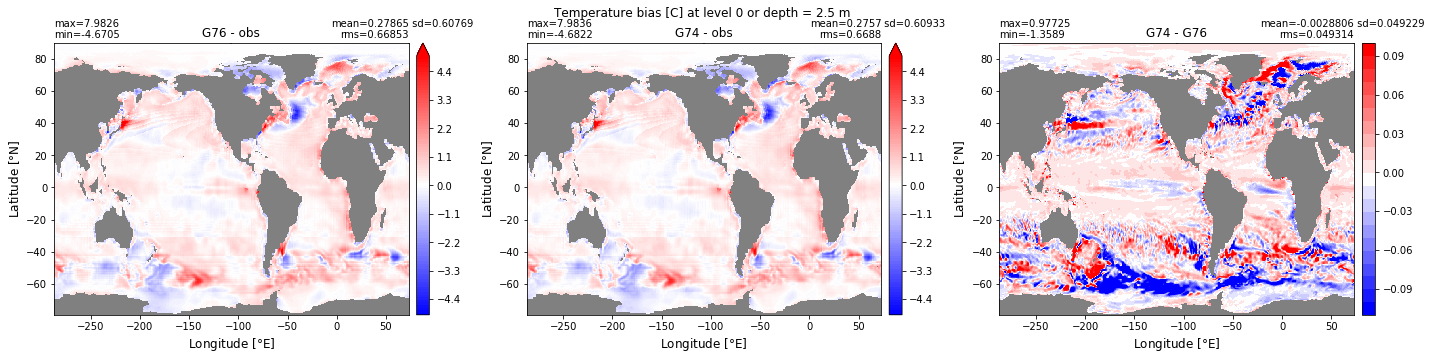

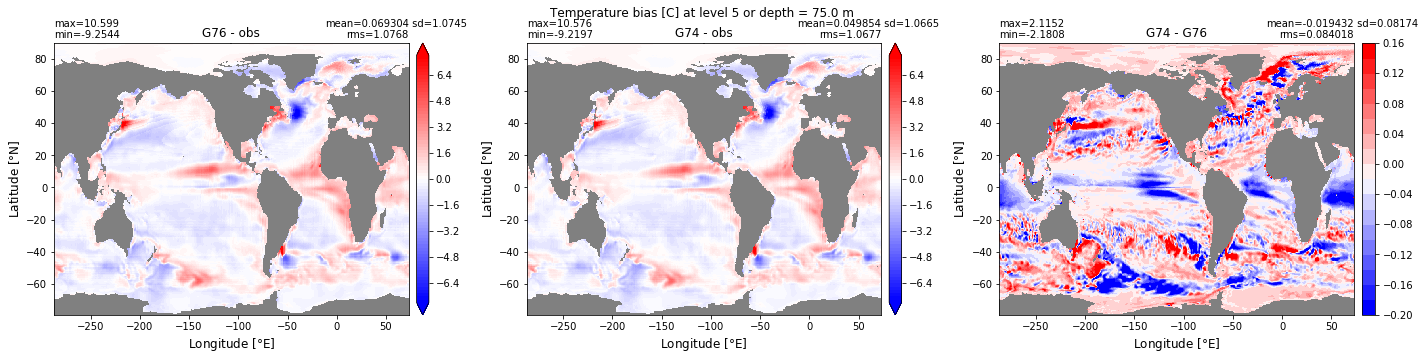

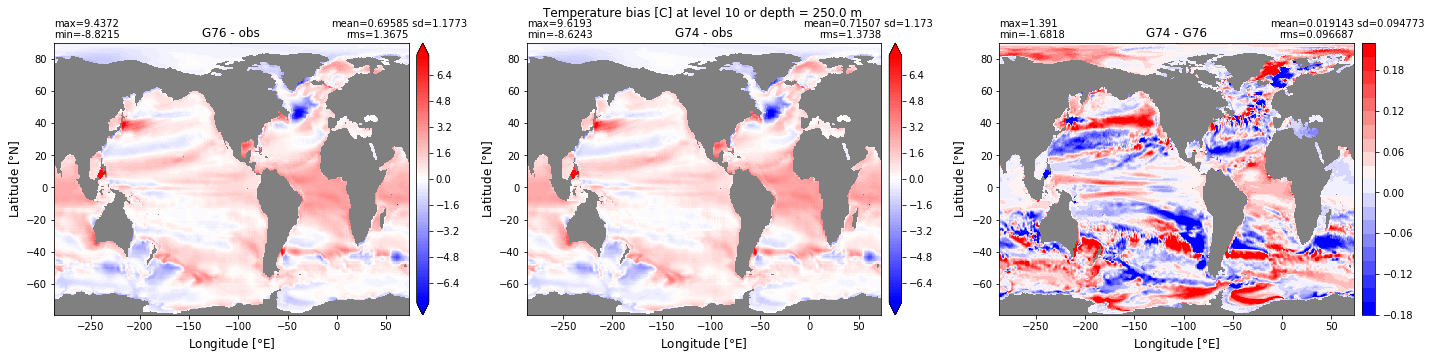

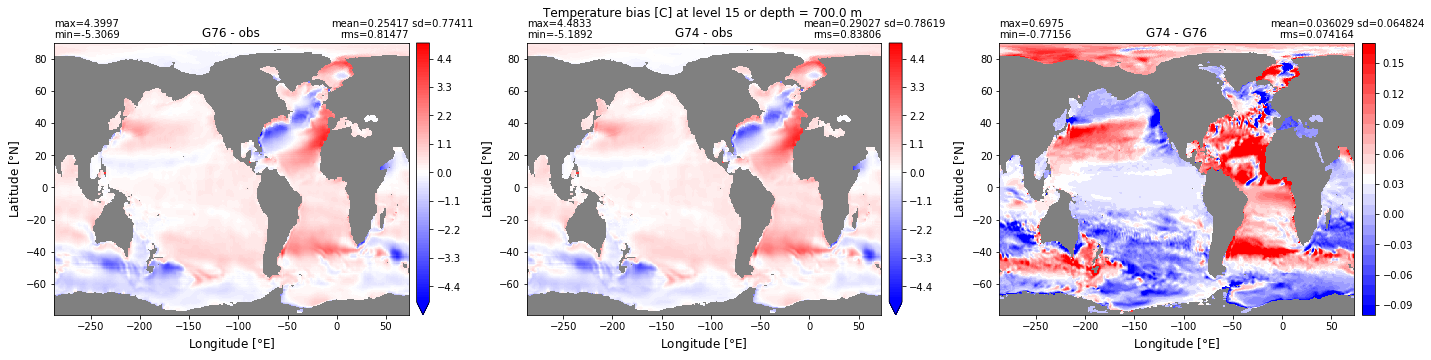

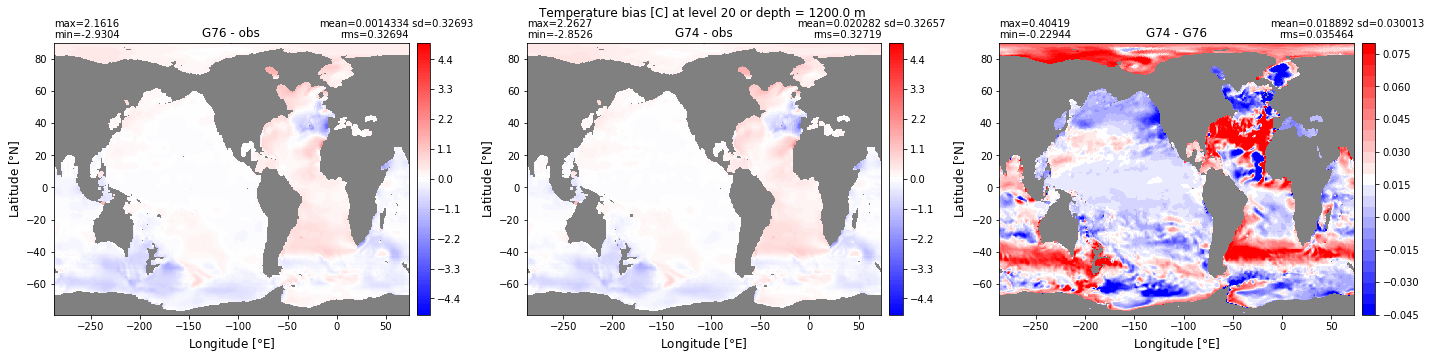

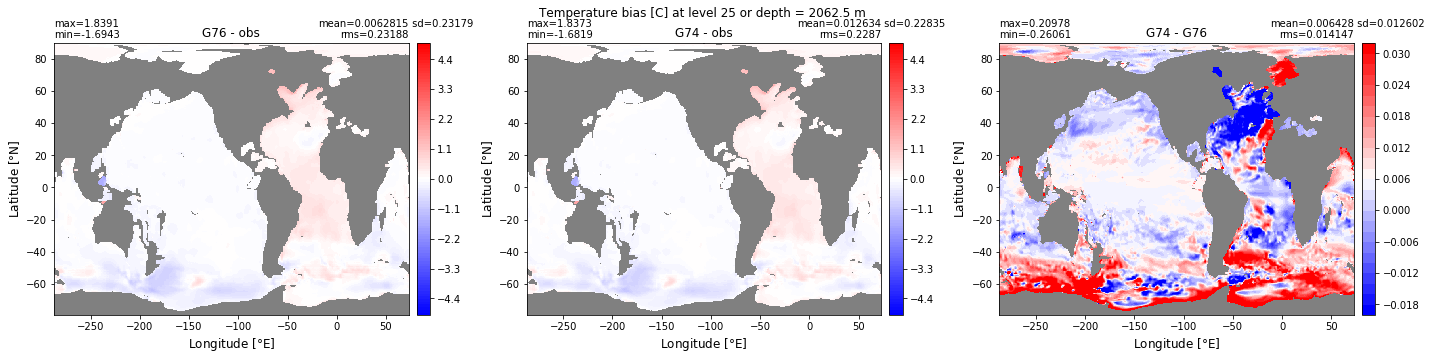

In [37]:
%matplotlib inline
# change k indice to see bias at other depths
levels=[0,5,10,15,20,25]
tlim=[5,7.5,7.5,5,5,5]
for k,t in zip(levels,tlim):
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,5.))
  ax1 = ax.flatten()
  temp_mom1 = np.ma.masked_invalid(ds_mom1_t.thetao[k,:].values)
  temp_mom2 = np.ma.masked_invalid(ds_mom2_t.thetao[k,:].values)
  temp_mom_obs = np.ma.masked_invalid(phc_temp_mom['TEMP'][k,:].values)
  
  plt.suptitle('Temperature bias [C] at level {} or depth = {} m'.format(k, 
               phc_temp_mom.depth[k].values))
  xyplot(temp_mom1-temp_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[0]+' - obs'), axis=ax1[0], 
         clim=(-t,t), nbins=100, colormap=plt.cm.bwr, centerlabels=True)
  xyplot(temp_mom2-temp_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[1]+' - obs'), axis=ax1[1], 
         clim=(-t,t), nbins=100, colormap=plt.cm.bwr, centerlabels=True)
  xyplot(temp_mom2-temp_mom1, grd.geolon, grd.geolat, grd.area_t, title=str(labels[1]+' - '+labels[0]), axis=ax1[2], 
         nbins=30, colormap=plt.cm.bwr)

In [38]:
ds_mom1_s = xr.open_dataset('../../'+exps[0]+'/ncfiles/'+exps[0]+'_so_time_mean.nc')
ds_mom2_s = xr.open_dataset('../../'+exps[1]+'/first_cycle/ncfiles/'+exps[1]+'_so_time_mean.nc')

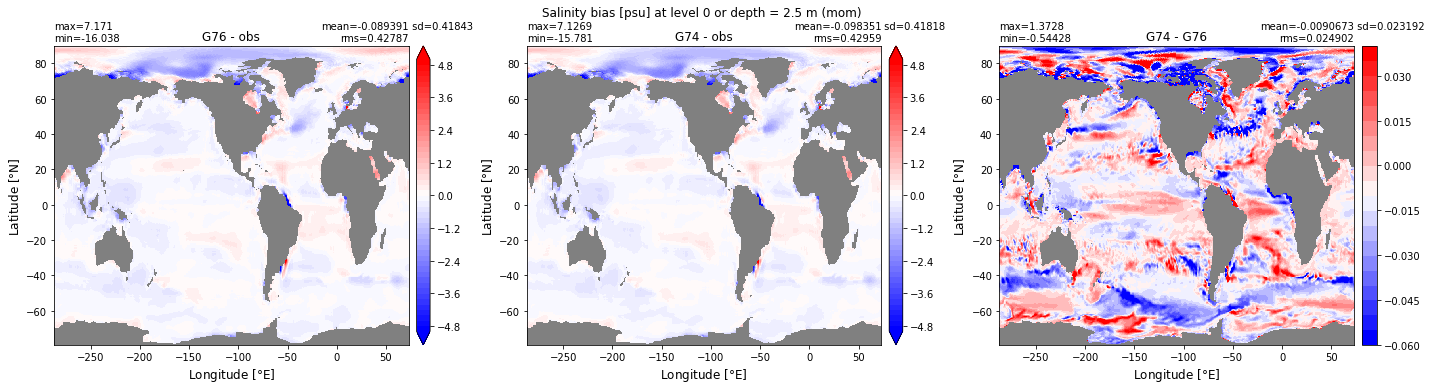

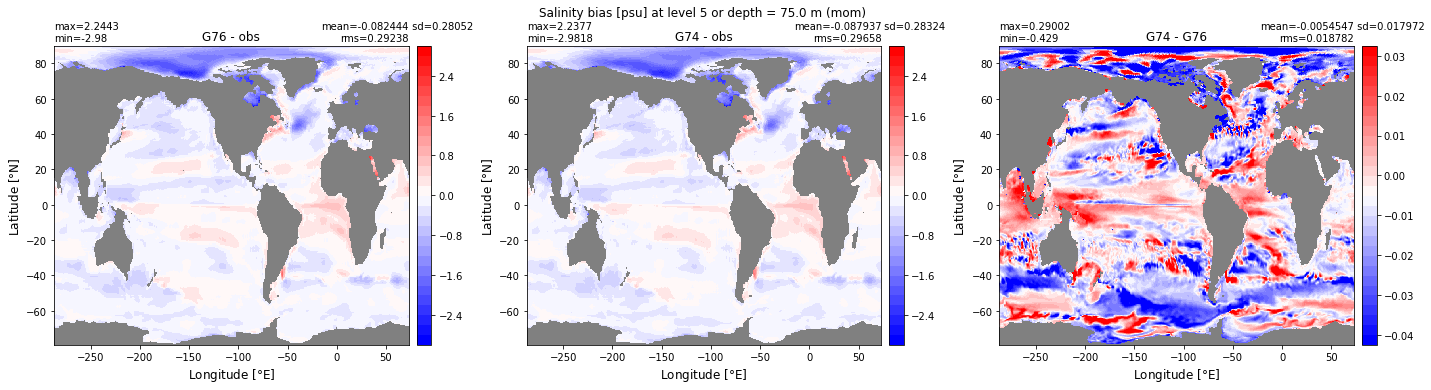

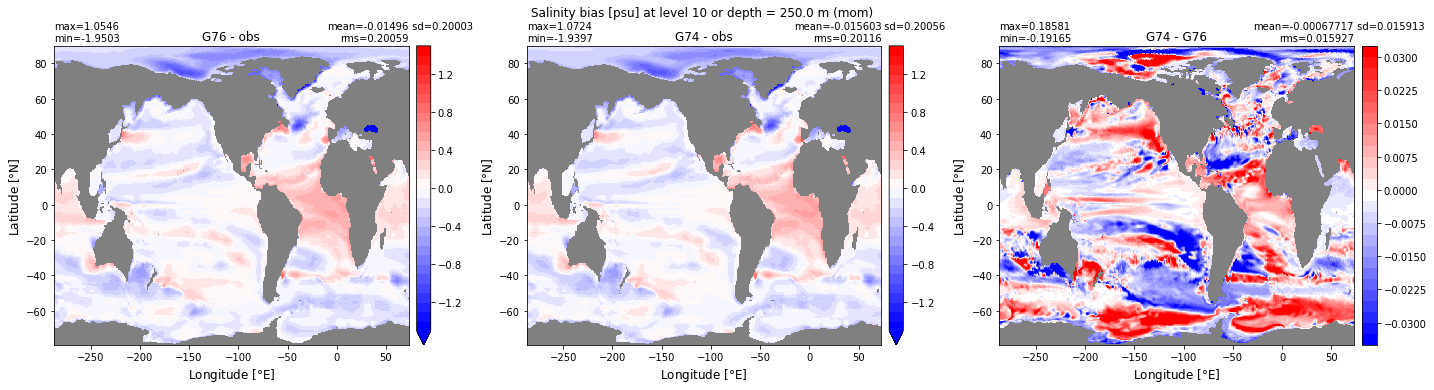

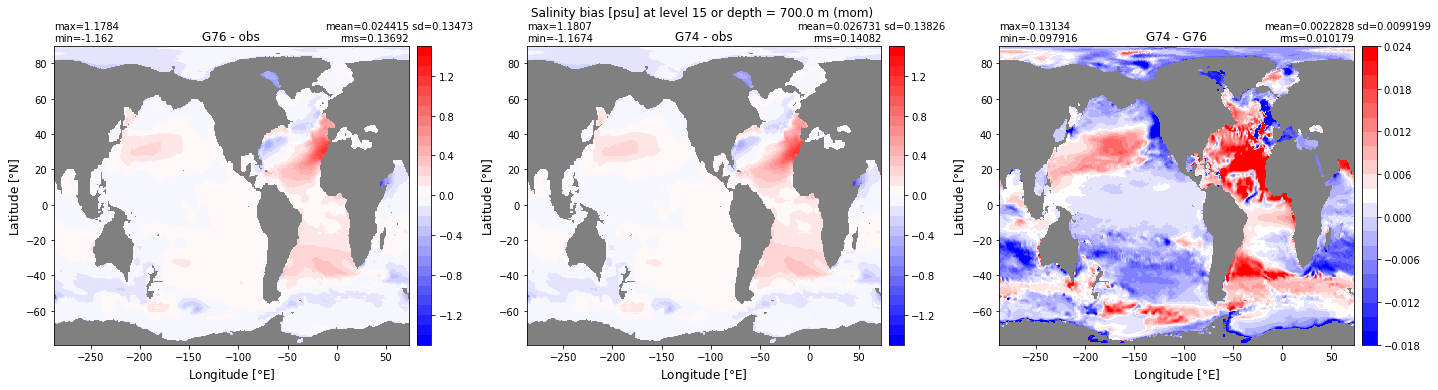

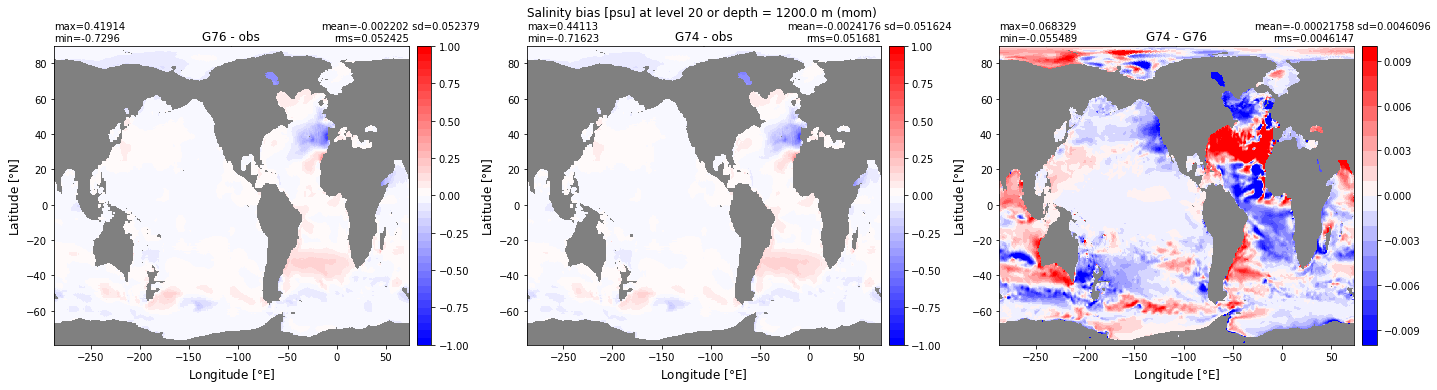

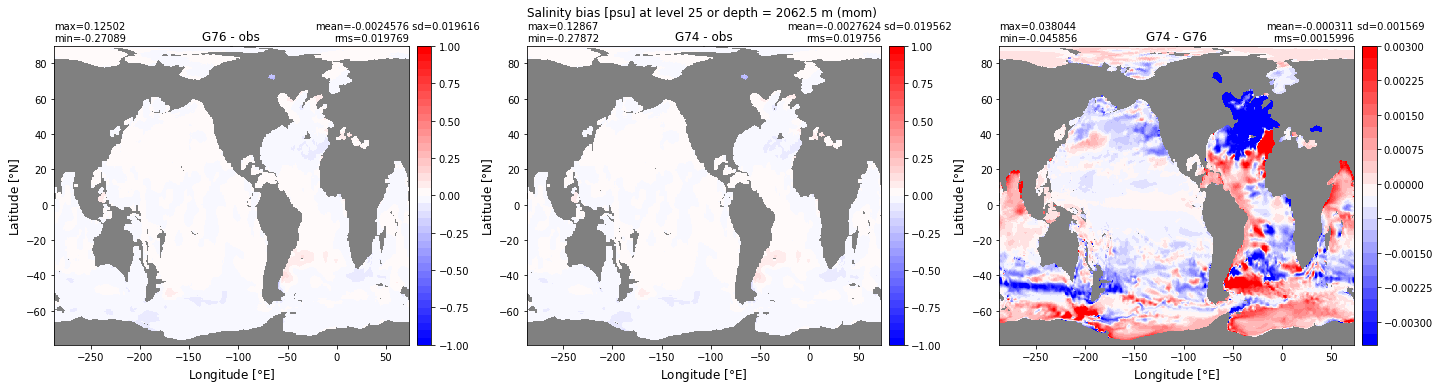

In [39]:
%matplotlib inline
# change k indice to see bias at other depths
levels=[0,5,10,15,20,25]
slim=[5,3,1.5,1.5,1,1]
for k,s in zip(levels,slim):
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,5.5))
  ax1 = ax.flatten()
  salt_mom1 = np.ma.masked_invalid(ds_mom1_s.so[k,:].values)
  salt_mom2 = np.ma.masked_invalid(ds_mom2_s.so[k,:].values)
  salt_mom_obs = np.ma.masked_invalid(phc_salt_mom['SALT'][k,:].values)
  
  plt.suptitle('Salinity bias [psu] at level {} or depth = {} m (mom)'.format(k, 
               phc_salt_mom.depth[k].values))
  xyplot(salt_mom1-salt_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[0]+' - obs'), axis=ax1[0], 
         clim=(-s,s), nbins=50, colormap=plt.cm.bwr, centerlabels=True)
  xyplot(salt_mom2-salt_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[1]+' - obs'), axis=ax1[1], 
         clim=(-s,s), nbins=50, colormap=plt.cm.bwr, centerlabels=True)
  xyplot(salt_mom2-salt_mom1, grd.geolon, grd.geolat, grd.area_t, title=str(labels[1]+' - '+labels[0]), axis=ax1[2], 
         nbins=30, colormap=plt.cm.bwr)

# Zonally averaged T/S Bias  

### Global

In [40]:
# MOM
# reconstruct interfaces
elev_mom = np.concatenate([0,np.diff(ds_mom1_t.z_l).cumsum(),6000.], axis=None)
[_, z_mom] = np.meshgrid(ds_mom1_t.yh.values, -elev_mom)

mom1_temp_bias = xr.DataArray((ds_mom1_t.thetao.values) - (phc_temp_mom.TEMP.values), dims=('z_l', 'yh','xh'), 
                             coords={'z_l':ds_mom1_t.z_l, 'yh': ds_mom1_t.yh, 'xh':ds_mom1_t.xh})
mom1_salt_bias = xr.DataArray((ds_mom1_s.so.values) - (phc_salt_mom.SALT.values), dims=('z_l', 'yh','xh'), 
                             coords={'z_l':ds_mom1_t.z_l, 'yh': ds_mom1_t.yh, 'xh':ds_mom1_t.xh})

mom2_temp_bias = xr.DataArray((ds_mom2_t.thetao.values) - (phc_temp_mom.TEMP.values), dims=('z_l', 'yh','xh'), 
                             coords={'z_l':ds_mom2_t.z_l, 'yh': ds_mom2_t.yh, 'xh':ds_mom2_t.xh})
mom2_salt_bias = xr.DataArray((ds_mom2_s.so.values) - (phc_salt_mom.SALT.values), dims=('z_l', 'yh','xh'), 
                             coords={'z_l':ds_mom2_t.z_l, 'yh': ds_mom2_t.yh, 'xh':ds_mom2_t.xh})


area_mom = xr.DataArray(np.ma.masked_where(grd.wet == 0,grd.area_t), dims=('yh','xh'), coords={'yh': ds_mom1_t.yh, 'xh':ds_mom1_t.xh})

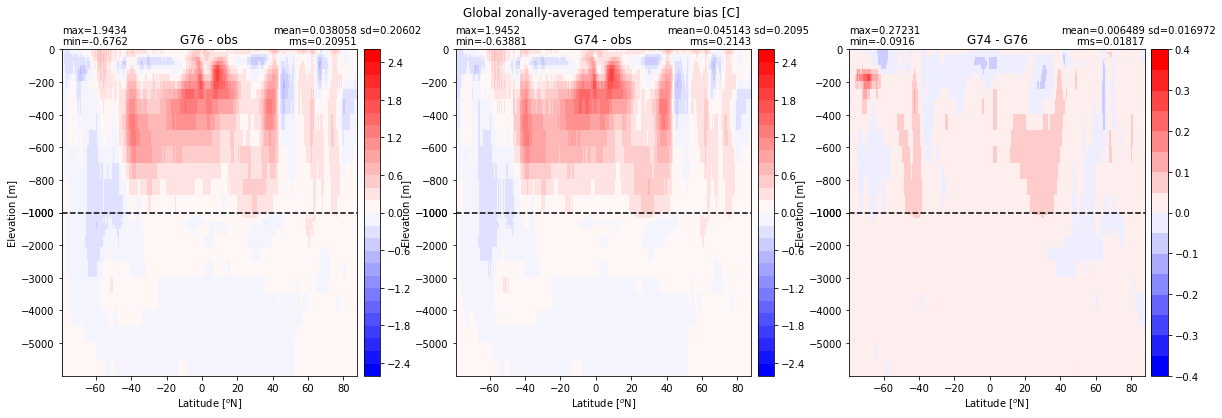

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6), sharex=True)
ax1 = ax.flatten()
plt.suptitle('Global zonally-averaged temperature bias [C]')
mom1_temp_global = ((mom1_temp_bias * area_mom).sum('xh')/area_mom.sum('xh'))
mom2_temp_global = ((mom2_temp_bias * area_mom).sum('xh')/area_mom.sum('xh'))


yzplot(np.ma.masked_invalid(mom1_temp_global), ds_mom1_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-2.5, 2.5), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[0].invert_yaxis()

yzplot(np.ma.masked_invalid(mom2_temp_global), ds_mom2_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]+' - obs'), 
       axis=ax1[1], nbins=30, colormap=plt.cm.bwr, clim=(-2.5, 2.5), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[1].invert_yaxis()

yzplot(np.ma.masked_invalid(mom2_temp_global-mom1_temp_global), ds_mom2_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]+' - '+labels[0]), 
       axis=ax1[2], nbins=30, colormap=plt.cm.bwr, splitscale=[0, -1000,-6000], centerlabels=True, clim=(-0.4, 0.4))
ax1[2].invert_yaxis()


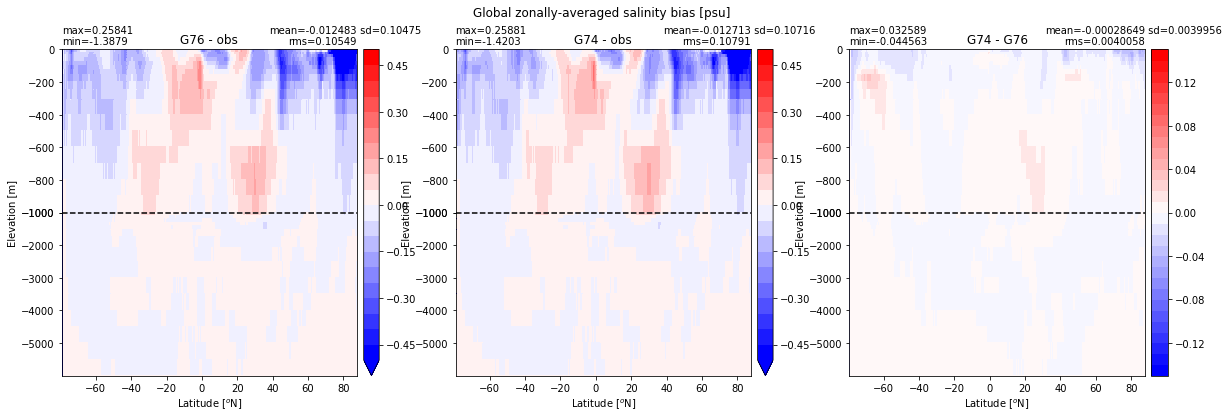

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6), sharex=True)
ax1 = ax.flatten()
plt.suptitle('Global zonally-averaged salinity bias [psu]')
mom1_salt_global = ((mom1_salt_bias * area_mom).sum('xh')/area_mom.sum('xh'))
mom2_salt_global = ((mom2_salt_bias * area_mom).sum('xh')/area_mom.sum('xh'))

yzplot(np.ma.masked_invalid(mom1_salt_global), ds_mom1_s.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-0.5, 0.5), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[0].invert_yaxis()
yzplot(np.ma.masked_invalid(mom2_salt_global), ds_mom2_s.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]+' - obs'), 
       axis=ax1[1], nbins=30, colormap=plt.cm.bwr, clim=(-0.5, 0.5), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[1].invert_yaxis()
yzplot(np.ma.masked_invalid(mom2_salt_global-mom1_salt_global), ds_mom2_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]+' - '+labels[0]), 
       axis=ax1[2], nbins=30, colormap=plt.cm.bwr, splitscale=[0, -1000,-6000], centerlabels=True, clim=(-0.15, 0.15))
ax1[2].invert_yaxis()

### Atlantic

In [44]:
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True)

11.16427964664149 64.78854837178643 [391, 434]


In [45]:
mom1_temp_alt = ((basin_code.sel(region='AtlanticOcean')*mom1_temp_bias * area_mom).sum('xh')/area_mom.sum('xh'))
mom1_salt_alt = ((basin_code.sel(region='AtlanticOcean')*mom1_salt_bias * area_mom).sum('xh')/area_mom.sum('xh'))
mom2_temp_alt = ((basin_code.sel(region='AtlanticOcean')*mom2_temp_bias * area_mom).sum('xh')/area_mom.sum('xh'))
mom2_salt_alt = ((basin_code.sel(region='AtlanticOcean')*mom2_salt_bias * area_mom).sum('xh')/area_mom.sum('xh'))

(-41, 75)

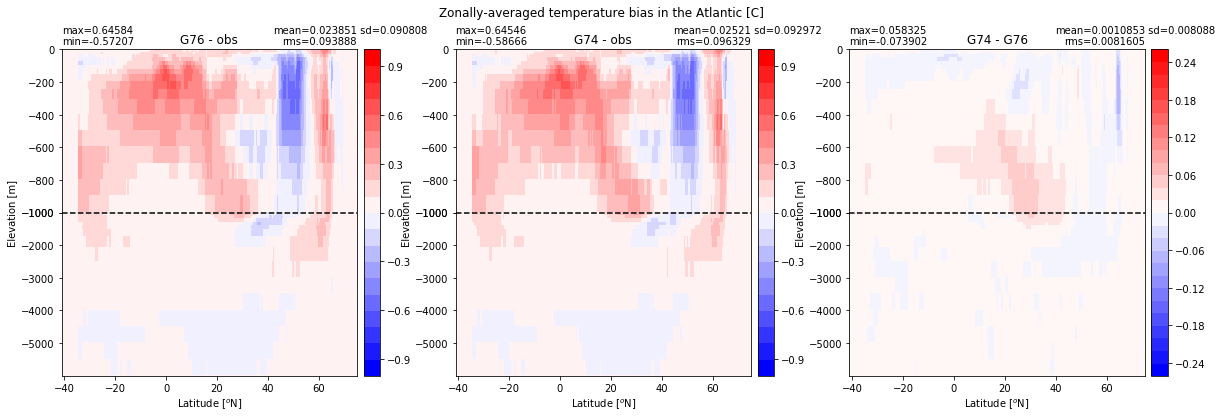

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6), sharex=True)
ax1 = ax.flatten()
plt.suptitle('Zonally-averaged temperature bias in the Atlantic [C]')
yzplot(np.ma.masked_invalid(mom1_temp_alt.transpose()), ds_mom1_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-1, 1), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(-41,75)

yzplot(np.ma.masked_invalid(mom2_temp_alt.transpose()), ds_mom2_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]+' - obs'), 
       axis=ax1[1], nbins=30, colormap=plt.cm.bwr, clim=(-1, 1), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(-41,75)

yzplot(np.ma.masked_invalid(mom2_temp_alt.transpose()-mom1_temp_alt.transpose()), ds_mom2_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]+' - '+labels[0]), 
       axis=ax1[2], nbins=30, colormap=plt.cm.bwr, splitscale=[0, -1000,-6000], centerlabels=True, clim=(-0.25, 0.25))
ax1[2].invert_yaxis(); ax1[2].set_xlim(-41,75)


(-41, 75)

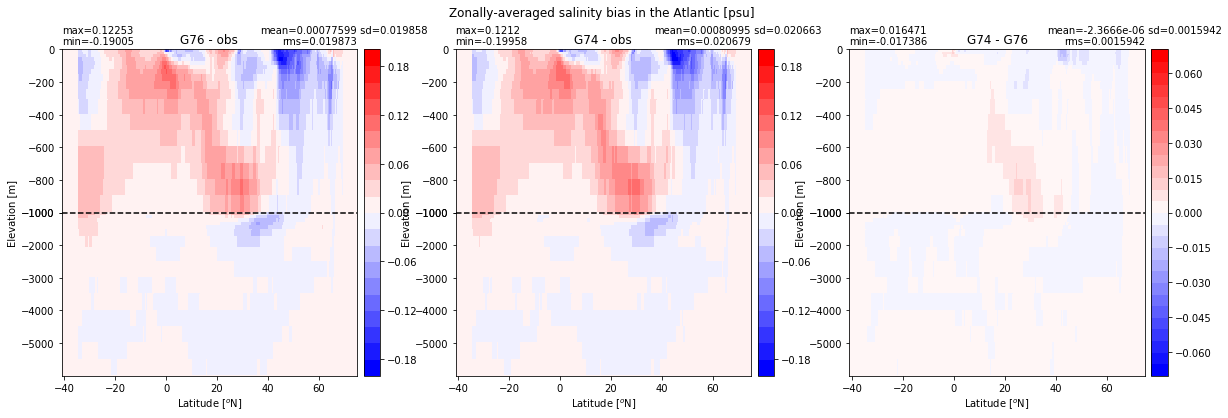

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
ax1 = ax.flatten()
plt.suptitle('Zonally-averaged salinity bias in the Atlantic [psu]')

yzplot(np.ma.masked_invalid(mom1_salt_alt.transpose()), ds_mom1_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-0.2, 0.2), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(-41,75)
yzplot(np.ma.masked_invalid(mom2_salt_alt.transpose()), ds_mom2_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]+' - obs'), 
       axis=ax1[1], nbins=30, colormap=plt.cm.bwr, clim=(-0.2, 0.2), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(-41,75)
yzplot(np.ma.masked_invalid((mom2_salt_alt-mom1_salt_alt).transpose()), ds_mom2_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[1]+' - '+labels[0]), 
       axis=ax1[2], nbins=30, colormap=plt.cm.bwr, splitscale=[0, -1000,-6000], centerlabels=True, clim=(-0.07, 0.07))
ax1[2].invert_yaxis(); ax1[2].set_xlim(-41,75)

### Med Sea

In [48]:
mom1_temp_med = ((basin_code.sel(region='MedSea')*mom1_temp_bias * area_mom).sum('xh')/area_mom.sum('xh'))
mom1_salt_med = ((basin_code.sel(region='MedSea')*mom1_salt_bias * area_mom).sum('xh')/area_mom.sum('xh'))
mom2_temp_med = ((basin_code.sel(region='MedSea')*mom2_temp_bias * area_mom).sum('xh')/area_mom.sum('xh'))
mom2_salt_med = ((basin_code.sel(region='MedSea')*mom2_salt_bias * area_mom).sum('xh')/area_mom.sum('xh'))

(30, 48)

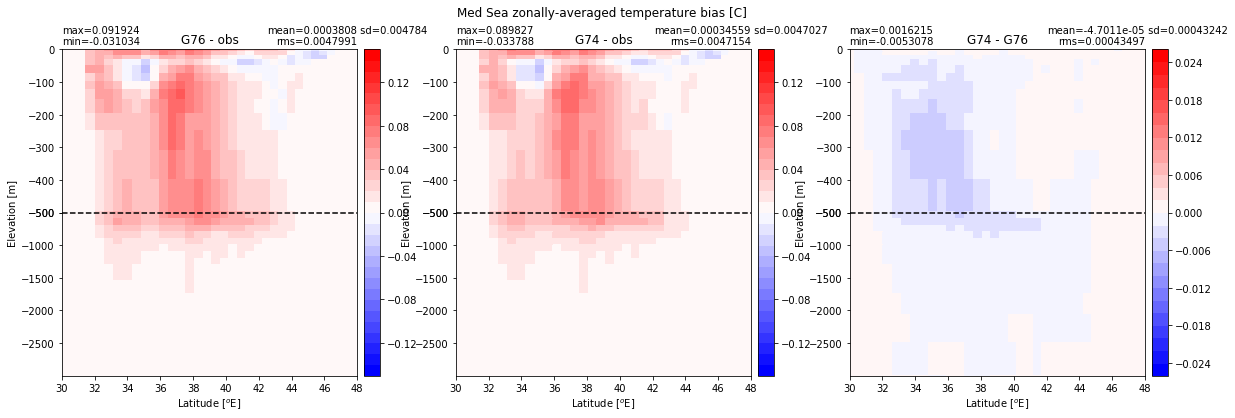

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
ax1 = ax.flatten()
plt.suptitle('Med Sea zonally-averaged temperature bias [C]')
yzplot(np.ma.masked_invalid(mom1_temp_med.transpose()), ds_mom1_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$E', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-0.15, 0.15), centerlabels=True, splitscale=[0, -500,-3000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(30,48)
yzplot(np.ma.masked_invalid(mom2_temp_med.transpose()), ds_mom2_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$E', title=str(labels[1]+' - obs'), 
       axis=ax1[1], nbins=30, colormap=plt.cm.bwr, clim=(-0.15, 0.15), centerlabels=True, splitscale=[0, -500,-3000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(30,48)

yzplot(np.ma.masked_invalid((mom2_temp_med-mom1_temp_med).transpose()), ds_mom2_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$E', title=str(labels[1]+' - '+labels[0]), 
       axis=ax1[2], nbins=30, colormap=plt.cm.bwr, splitscale=[0, -500,-3000], centerlabels=True, clim=(-0.025, 0.025))
ax1[2].invert_yaxis(); ax1[2].set_xlim(30,48)


(30, 48)

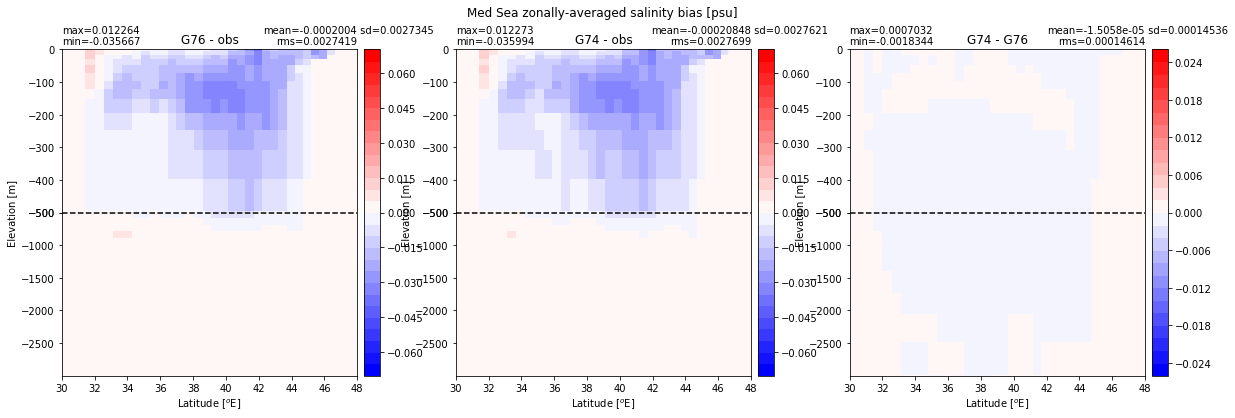

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
ax1 = ax.flatten()
plt.suptitle('Med Sea zonally-averaged salinity bias [psu]')
yzplot(np.ma.masked_invalid(mom1_salt_med.transpose()), ds_mom1_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$E', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-0.07, 0.07), centerlabels=True, splitscale=[0, -500,-3000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(30,48)
yzplot(np.ma.masked_invalid(mom2_salt_med.transpose()), ds_mom2_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$E', title=str(labels[1]+' - obs'), 
       axis=ax1[1], nbins=30, colormap=plt.cm.bwr, clim=(-0.07, 0.07), centerlabels=True, splitscale=[0, -500,-3000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(30,48)

yzplot(np.ma.masked_invalid((mom2_salt_med-mom1_salt_med).transpose()), ds_mom2_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$E', title=str(labels[1]+' - '+labels[0]), 
       axis=ax1[2], nbins=30, colormap=plt.cm.bwr, splitscale=[0, -500,-3000], centerlabels=True, clim=(-0.025, 0.025))
ax1[2].invert_yaxis(); ax1[2].set_xlim(30,48)
